- http://keunwoochoi.blogspot.com/2016/03/2.html
- http://www.rex-ai.info/docs/AI_Example_CNN_speech_recognize
- https://www.youtube.com/watch?v=oltGIc4uo5c
- https://youdaeng-com.tistory.com/5
- https://quokkas.tistory.com/37 : early stopping
- https://continuous-development.tistory.com/166 : stratified kfold
- https://deep-learning-study.tistory.com/476 fiter 시각화
- https://wyatt37.tistory.com/10 : random over sampling

In [1]:
import wandb

wandb.init(project="SVD-voice-disorder", entity="bub3690")
wandb.run.name = 'septr-organics-speaker'
wandb.run.save()

wandb: Currently logged in as: bub3690. Use `wandb login --relogin` to force relogin


wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


True

In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn # 인공 신경망 모델들 모아놓은 모듈
import torch.nn.functional as F #그중 자주 쓰이는것들을 F로
from torchvision import transforms, datasets
import cv2
from torchvision import transforms, datasets
import pandas as pd
import os
from glob import glob
import torchvision.models as models
import sys

p = os.path.abspath('../../../..') # 상위 폴더를 사용하기 위해서.
sys.path.insert(1, p)
from pytorchtools.pytorchtools import EarlyStopping # 상위 폴더에 추가된 모듈.


if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
#DEVICE = torch.device('cpu')
print('Using Pytorch version : ',torch.__version__,' Device : ',DEVICE)

Using Pytorch version :  1.10.2  Device :  cuda


In [3]:
import torchaudio
#import torchaudio.functional as F
import torchaudio.transforms as T

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(1234)

# SVD 문장 데이터에서 Feature 추출
- mfcc

In [4]:
import numpy as np
import librosa, librosa.display 
import matplotlib.pyplot as plt
#window sizde : FFT를 할때 참조할 그래프 길이 ( 프레임 하나당 sample 수 )
#자연어 처리에서는 25ms 사용. https://ahnjg.tistory.com/93
#초당 50000hz 중 1250개씩 윈도우 사이즈로 사용.


#default param
mfcc_run_config = dict(
    sr=16000,
    n_mfcc=27,
    #dct_type=3, # type2 default
    lifter = 35,

    
    #mel spectro
    n_mels=170,
    hop_length=750,
    n_fft =14056,    
    win_length=1100,
    f_max=8000,
    
    # training
    #batch_size=32,
    mel_scale ='htk',
    
    # data
    fold=1,
)

mel_run_config = dict(
    sr=16000,
    n_mels=128,
    win_length =  300,
    n_fft= 2048,
    hop_length= 50,
    f_max = 8000    
)


spectro_run_config =dict(
    sr=16000,
    n_fft=350,
    hop_length=50,
    win_length=350,
    # training
    batch_size=16,
)




#또는 10ms만큼으로 한다고 한다.
#hop_length가 mfcc의 frame수를 결정한다.

# 데이터 나누기 - Stratified KFold

- pathology : 1194 / healthy : 634 / 총 1828
- k = 5

## 1. test/ train 나누기


In [5]:
speaker_data=pd.read_excel("D:/project/voice_pathology_ai/voice_data/only_organics_healthy_available.xlsx")

In [6]:
pathology = speaker_data[speaker_data['PATHOLOGY']=='p']['SPEAKER'].unique().tolist()
healthy = speaker_data[speaker_data['PATHOLOGY']=='n']['SPEAKER'].unique().tolist()
print(len(pathology))
print(len(healthy))

427
630


In [7]:
#겹치는 speaker는 곱하기 100을 해준다.
#3명이 겹친다.
changed_patients = list(set(healthy) & set(pathology))

for patient in changed_patients:
    temp=pathology[pathology.index(patient)]*100
    pathology[pathology.index(patient)] = temp
    

In [8]:
#train test 나누기

import os
from glob import glob
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.model_selection import train_test_split # train , test 분리에 사용.


X = pathology+healthy # path 데이터 합
print("총 데이터수 : ",len(X))
Y = [] # 라벨
for idx,x in enumerate(X):
    if idx<427:
        Y.append("pathology")
    else:
        Y.append("healthy")

X, X_test, Y, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, stratify=Y, random_state=789) #456
#stratify를 넣어서, test에도 라벨별 잘 분류되게 한다.

print("---")
print("훈련 셋 : ",len(Y),Counter(Y))
print("테스트 셋 : ",len(Y_test),Counter(Y_test))
print("---")



총 데이터수 :  1057
---
훈련 셋 :  845 Counter({'healthy': 504, 'pathology': 341})
테스트 셋 :  212 Counter({'healthy': 126, 'pathology': 86})
---


## 2. stratified k-fold

In [9]:
#1. train, test 나누기
#stratified kfold
import os
import random #데이터 shuffle 사용
from glob import glob
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
from collections import Counter



skf_iris = StratifiedKFold(n_splits=5,shuffle=True,random_state=456)
cnt_iter = 0

X_train_list = [] #데이터 셋 보관
Y_train_list = []

X_valid_list = []
Y_valid_list = []

for train_idx, test_idx in skf_iris.split(X,Y):
    
    #split으로 반환된 인덱스를 이용하여, 학습 검증용 테스트 데이터 추출
    cnt_iter += 1
    X_train, X_valid = [X[idx] for idx in train_idx.tolist() ], [X[idx] for idx in test_idx.tolist() ]
    Y_train, Y_valid = [Y[idx] for idx in train_idx.tolist() ], [Y[idx] for idx in test_idx.tolist() ]
    
    X_train_list.append(X_train)
    X_valid_list.append(X_valid)
    
    Y_train_list.append(Y_train)
    Y_valid_list.append(Y_valid)
    
    
    #학습 및 예측
    
    label_train = Y_train
    label_test = Y_valid
    unique_train, train_counts = np.unique(label_train, return_counts = True)
    unique_test, test_counts = np.unique(label_test, return_counts = True)
    
    uniq_cnt_train = dict(zip(unique_train, train_counts))
    uniq_cnt_test = dict(zip(unique_test, test_counts))
    
    
    
    print('교차 검증 : {}'.format(cnt_iter))
    print('학습 레이블 데이터 분포 : \n', uniq_cnt_train)
    print('검증 레이블 데이터 분포 : \n', uniq_cnt_test,'\n')



교차 검증 : 1
학습 레이블 데이터 분포 : 
 {'healthy': 403, 'pathology': 273}
검증 레이블 데이터 분포 : 
 {'healthy': 101, 'pathology': 68} 

교차 검증 : 2
학습 레이블 데이터 분포 : 
 {'healthy': 403, 'pathology': 273}
검증 레이블 데이터 분포 : 
 {'healthy': 101, 'pathology': 68} 

교차 검증 : 3
학습 레이블 데이터 분포 : 
 {'healthy': 403, 'pathology': 273}
검증 레이블 데이터 분포 : 
 {'healthy': 101, 'pathology': 68} 

교차 검증 : 4
학습 레이블 데이터 분포 : 
 {'healthy': 403, 'pathology': 273}
검증 레이블 데이터 분포 : 
 {'healthy': 101, 'pathology': 68} 

교차 검증 : 5
학습 레이블 데이터 분포 : 
 {'healthy': 404, 'pathology': 272}
검증 레이블 데이터 분포 : 
 {'healthy': 100, 'pathology': 69} 



# speaker to voice

In [10]:
# speaker to voice

all_train_record_list = []
all_valid_record_list = []
all_test_record_list = []

all_train_label_list = []
all_valid_label_list = []
all_test_label_list = []

#train
for fold_idx,fold in enumerate(X_train_list):
    fold_record=[]
    fold_y_record=[]
    for idx,speaker in enumerate(fold):
        record_list = speaker_data[speaker_data['SPEAKER']==speaker]['RECORDING'].tolist()
        label_list = [ Y_train_list[fold_idx][idx] ] * len(record_list)
        
        fold_record += record_list
        fold_y_record += label_list
    all_train_record_list.append(fold_record)
    all_train_label_list.append(fold_y_record)

    
#valid
for fold_idx,fold in enumerate(X_valid_list):
    fold_record=[]
    fold_y_record=[]
    for idx,speaker in enumerate(fold):
        record_list = speaker_data[speaker_data['SPEAKER']==speaker]['RECORDING'].tolist()
        label_list = [ Y_valid_list[fold_idx][idx] ] * len(record_list)
        
        fold_record += record_list
        fold_y_record += label_list
    all_valid_record_list.append(fold_record)
    all_valid_label_list.append(fold_y_record)
    
#test
fold_record=[]
fold_y_record=[]
for idx,speaker in enumerate(X_test):
    record_list = speaker_data[speaker_data['SPEAKER']==speaker]['RECORDING'].tolist()
    label_list = [ Y_test[idx] ] * len(record_list)
    fold_record += record_list
    fold_y_record += label_list
all_test_record_list = fold_record
all_test_label_list = fold_y_record


X_train_list = all_train_record_list
X_valid_list = all_valid_record_list
X_test = all_test_record_list

Y_train_list = all_train_label_list
Y_valid_list = all_valid_label_list
Y_test = all_test_label_list



## 3. random over sampling

In [11]:
#2. random over sampling
for i in range(5):
    X_temp = np.array(X_train_list[i]).reshape(-1,1)#각 데이터를 다 행으로 넣음. (1194,1)
    #Y = np.array(Y)
    ros = RandomOverSampler(random_state = 123)
    X_res,Y_res = ros.fit_resample(X_temp,Y_train_list[i])
    
    print("\n fold{} ".format(i))
    print('before dataset shape {}'.format(Counter(Y_train_list[i])) )
    print('Resampled dataset shape {}'.format(Counter(Y_res)) )   
    
    #원래대로 돌리기
    X_res=X_res.reshape(1, -1)
    X_train_list[i]=X_res[0].tolist()
    Y_train_list[i]=Y_res





 fold0 
before dataset shape Counter({'healthy': 405, 'pathology': 360})
Resampled dataset shape Counter({'healthy': 405, 'pathology': 405})

 fold1 
before dataset shape Counter({'healthy': 406, 'pathology': 375})
Resampled dataset shape Counter({'healthy': 406, 'pathology': 406})

 fold2 
before dataset shape Counter({'healthy': 407, 'pathology': 355})
Resampled dataset shape Counter({'healthy': 407, 'pathology': 407})

 fold3 
before dataset shape Counter({'healthy': 406, 'pathology': 385})
Resampled dataset shape Counter({'healthy': 406, 'pathology': 406})

 fold4 
before dataset shape Counter({'healthy': 408, 'pathology': 381})
Resampled dataset shape Counter({'pathology': 408, 'healthy': 408})


In [12]:
import pickle


    
#load
with open("D:/project/voice_pathology_ai/voice_data/organics/phrase_sig_dict.pickle","rb") as fr:
    phrase_dict = pickle.load(fr)

with open("D:/project/voice_pathology_ai/voice_data/organics/phrase_minmax_scaler_hyper.pickle","rb") as fr:
    phrase_scaler = pickle.load(fr)
    

# 데이터 정의
- 추가적으로 데이터의 크기를 맞춰주기 위해 3초로 padding 및 truncate 실시 https://sequencedata.tistory.com/25 FixAudioLength
- 논문에서는 400frame으로 설정.(여기서는 500frame)
- 전처리 방법 결정.


In [13]:
# 데이터 로더

In [13]:
#default param
mfcc_run_config = dict(
    sr=16000,
    n_mfcc=27,
    #dct_type=3, # type2 default
    lifter = 35,

    
    #mel spectro
    n_mels=170,
    hop_length=750,
    n_fft =14056,    
    win_length=1100,
    f_max=8000,
    
    # training
    #batch_size=32,
    mel_scale ='htk',
    
    # data
    fold=1,
)

mel_run_config = dict(
    sr=16000,
    n_mels=128,
    win_length =  300,
    n_fft= 2048,
    hop_length= 50,
    f_max = 8000    
)


spectro_run_config =dict(
    sr=16000,
    n_fft=350,
    hop_length=50,
    win_length=350,
    # training
    batch_size=16,
)




In [15]:
# https://github.com/astorfi/speechpy/blob/master/speechpy/processing.py

def cmvn(vec, variance_normalization=False):
    """ This function is aimed to perform global cepstral mean and
        variance normalization (CMVN) on input feature vector "vec".
        The code assumes that there is one observation per row.
    Args:
        vec (array): input feature matrix
            (size:(num_observation,num_features))
        variance_normalization (bool): If the variance
            normilization should be performed or not.
    Return:
          array: The mean(or mean+variance) normalized feature vector.
    """
    eps = 2**-30
    rows, cols = vec.shape

    # Mean calculation
    norm = torch.mean(vec, axis=1)
    norm_vec = torch.tile(norm, (rows, 1))
    
    # Mean subtraction
    mean_subtracted = vec - norm_vec

    # Variance normalization
    if variance_normalization:
        stdev = torch.std(mean_subtracted, axis=1)
        stdev_vec = torch.tile(stdev, (rows, 1))
        output = mean_subtracted / (stdev_vec + eps)
    else:
        output = mean_subtracted

    return output

In [16]:
# https://github.com/astorfi/speechpy/blob/master/speechpy/processing.py

def cmvn_spectro(vec,origin_frame_size,variance_normalization=False,):
    """ This function is aimed to perform global cepstral mean and
        variance normalization (CMVN) on input feature vector "vec".
        The code assumes that there is one observation per row.
    Args:
        vec (array): input feature matrix
            (size:(num_observation,num_features))
        variance_normalization (bool): If the variance
            normilization should be performed or not.
    Return:
          array: The mean(or mean+variance) normalized feature vector.
    """
    eps = 2**-30
    cols, rows = vec.shape

    # Mean calculation
    norm = np.mean(vec[:,:origin_frame_size], axis=1)
    norm = np.expand_dims(norm,axis=1)
    norm_vec = np.tile(norm, (1,rows))

    # Mean subtraction
    mean_subtracted = vec - norm_vec

    # Variance normalization
    if variance_normalization:
        stdev = np.std(mean_subtracted[:,:origin_frame_size], axis=1)
        stdev = np.expand_dims(stdev,axis=1)
        stdev_vec = np.tile(stdev, (1,rows))
        output = mean_subtracted / (stdev_vec + eps)
    else:
        output = mean_subtracted

    return output

In [17]:
def cmvnw_mfcc(vec, win_size=301, variance_normalization=False):
    """ This function is aimed to perform local cepstral mean and
    variance normalization on a sliding window. The code assumes that
    there is one observation per row.
    Args:
        vec (array): input feature matrix
            (size:(num_observation,num_features))
        win_size (int): The size of sliding window for local normalization.
            Default=301 which is around 3s if 100 Hz rate is
            considered(== 10ms frame stide)
        variance_normalization (bool): If the variance normilization should
            be performed or not.
    Return:
          array: The mean(or mean+variance) normalized feature vector.
    """
    # Get the shapes
    eps = 2**-30
    rows, cols = vec.shape

    # Windows size must be odd.
    assert isinstance(win_size, int), "Size must be of type 'int'!"
    assert win_size % 2 == 1, "Windows size must be odd!"

    # Padding and initial definitions
    pad_size = int((win_size - 1) / 2)
    vec_pad = np.lib.pad(vec, ((pad_size, pad_size), (0, 0)), 'symmetric')
    mean_subtracted = np.zeros(np.shape(vec), dtype=np.float32)

    for i in range(rows):
        window = vec_pad[i:i + win_size, :]
        window_mean = np.mean(window, axis=0)
        mean_subtracted[i, :] = vec[i, :] - window_mean

    # Variance normalization
    if variance_normalization:

        # Initial definitions.
        variance_normalized = np.zeros(np.shape(vec), dtype=np.float32)
        vec_pad_variance = np.lib.pad(
            mean_subtracted, ((pad_size, pad_size), (0, 0)), 'symmetric')

        # Looping over all observations.
        for i in range(rows):
            window = vec_pad_variance[i:i + win_size, :]
            window_variance = np.std(window, axis=0)
            variance_normalized[i, :] \
            = mean_subtracted[i, :] / (window_variance + eps)
        output = variance_normalized
    else:
        output = mean_subtracted

    return output


In [18]:
def preemphasis(signal, shift=1, cof=0.98):
    """preemphasising on the signal.
    Args:
        signal (array): The input signal.
        shift (int): The shift step.
        cof (float): The preemphasising coefficient. 0 equals to no filtering.
    Returns:
           array: The pre-emphasized signal.
    """

    rolled_signal = np.roll(signal, shift)
    return signal - cof * rolled_signal

In [24]:
from torch.utils.data import Dataset, DataLoader

classes = ["healthy","pathology"]


class svd_dataset(Dataset):
    def __init__(self,data_path_list,classes,data_num,training,mfcc_params,mel_params,spectro_params,transform=None,normalize=None,mfcc_normalize=None):
        #클래스에서 사용할 인자를 받아 인스턴스 변수로 저장하는 일을 한다.
        #예를들면, 이미지의 경로 리스트를 저장하는 일을 하게 된다.
        
        #data_num : k 개 데이터 셋 중 어떤것을 쓸지
        #test인지 아닌지.
        
        self.path_list = data_path_list[data_num]
        self.data_num = data_num
        self.training = training
        self.label = svd_dataset.get_label(self.path_list,training,data_num)
        self.classes=classes
        self.transform=transform
        self.normalize=normalize
        self.mfcc_normalize = mfcc_normalize
        # sweep params
        self.mel_params = mel_params
        self.spectro_params = spectro_params
        self.mfcc_params = mfcc_params

        #sr,n_mfcc,lifter, hop_length , win_length , n_mels , n_fft , f_max , batch_size      
        
    
    @classmethod
    def get_label(cls,data_path_list,training,data_num):
        label_list=[]
        
        if training:
            for idx,x in enumerate(data_path_list):
                label_list.append(Y_train_list[data_num][idx])
        else:
            for idx,x in enumerate(data_path_list):
                label_list.append(Y_valid_list[data_num][idx])
        #print(label_list)
        return label_list
    
    
    def __len__(self):
        return len(self.path_list)
        #데이터 셋의 길이를 정수로 반환한다.     
    
       
    def __getitem__(self, idx):
        """
        1. path를 받아서, 소리에서 mfcc를 추출
        2. mfcc를 224프레임으로 패딩.
        3. resnet에 사용되기 위해 3채널로 복사(rgb 처럼)
        4. 0~1 정규화
        
        """
        sig = phrase_dict[ str(self.path_list[idx])+'-phrase.wav'] 
        #sig = preemphasis(sig)
        
        origin_length = sig.shape[0]
        
        if sig.shape[0]>self.mfcc_params["sr"]*2:
            origin_length = self.mfcc_params["sr"]*2
        
        origin_frame_size = 1 + int(np.floor(origin_length//self.mel_params["hop_length"]))
        
        length = self.mfcc_params["sr"]*2 #sample rate *2 padding을 위한 파라미터 (하이퍼 파라미터로인해 사이즈는 계속 바뀐다.)
        pad1d = lambda a, i: a[0:i] if a.shape[0] > i else np.hstack((a, np.zeros((i-a.shape[0]))))        
        sig = pad1d(sig,length)        
        
        ###signal norm
        sig = (sig-sig.mean())/sig.std()
        ###
        
        mel_feature = librosa.feature.melspectrogram(y=sig,
                                                     sr=self.mel_params["sr"],
                                                     # hyp param
                                                     n_mels = self.mel_params["n_mels"],
                                                     n_fft = self.mel_params["n_fft"],
                                                     win_length = self.mel_params["win_length"],
                                                     hop_length = self.mel_params["hop_length"],
                                                     fmax = self.mel_params["f_max"]
                                                    )
        mel_feature = librosa.core.power_to_db(mel_feature,ref=np.max) 
        
   
        
        #MFCCs = librosa.power_to_db(MFCCs)
        #MFCCs=cmvn(MFCCs,True)
        #log_spectrogram = np.divide(log_spectrogram-log_spectrogram.mean(axis=1),log_spectrogram.std(axis=1))
        #mel_feature = np.divide(mel_feature-mel_feature.mean(axis=1),mel_feature.std(axis=1))
        
        
        #log_spectrogram=cmvn_spectro(log_spectrogram,origin_frame_size,True)
        #mel_feature=cmvn_spectro(mel_feature,origin_frame_size,True)
        
        
        if self.transform:
            mel_feature = self.transform(mel_feature).type(torch.float32)# 데이터 0~1 정규화
            mel_feature = mel_feature.squeeze()
            
            # global normalize
            if self.normalize:
                mel_feature = self.normalize(mel_feature)
        else:
            pass
            #print("else")
            mel_feature = torch.from_numpy(mel_feature).type(torch.float32)
            mel_feature=mel_feature.unsqueeze(0)#cnn 사용위해서 추가
            #MFCCs = MFCCs.permute(2, 0, 1)
        return mel_feature,self.classes.index(self.label[idx])
    

In [25]:
# test set 제작을 위한 class
class svd_test_set(Dataset):
    def __init__(self,data_path_list,classes,mfcc_params,mel_params,spectro_params,transform=None,normalize=None,mfcc_normalize=None):
        #클래스에서 사용할 인자를 받아 인스턴스 변수로 저장하는 일을 한다.
        #예를들면, 이미지의 경로 리스트를 저장하는 일을 하게 된다.
        
        #data_num : k 개 데이터 셋 중 어떤것을 쓸지
        #test인지 아닌지.
        
        self.path_list = data_path_list
        self.label = svd_test_set.get_label(self.path_list)
        self.classes=classes
        self.transform=transform
        self.normalize=normalize
        self.mfcc_normalize = mfcc_normalize        
        
        # sweep params
        self.mel_params = mel_params
        self.spectro_params = spectro_params
        self.mfcc_params = mfcc_params
        #sr,n_mfcc,lifter, hop_length , win_length , n_mels , n_fft , f_max , batch_size           
    
    @classmethod
    def get_label(cls,data_path_list):
        label_list=[]
        
        for idx,x in enumerate(data_path_list):
            label_list.append(Y_test[idx])
        #print(label_list)
        return label_list
    
    def __len__(self):
        return len(self.path_list)
        #데이터 셋의 길이를 정수로 반환한다. 
        
    def __getitem__(self, idx):
        """
        1. path를 받아서, 소리에서 mfcc를 추출
        2. mfcc를 224프레임으로 패딩.
        3. resnet에 사용되기 위해 3채널로 복사(rgb 처럼)
        4. 0~1 정규화
        
        """
        sig = phrase_dict[ str(self.path_list[idx])+'-phrase.wav'] 
        #sig = preemphasis(sig)
        
        origin_length = sig.shape[0]
        
        if sig.shape[0]>self.mfcc_params["sr"]*2:
            origin_length = self.mfcc_params["sr"]*2
        
        origin_frame_size = 1 + int(np.floor(origin_length//self.mel_params["hop_length"]))
        
        length = self.mfcc_params["sr"]*2 #sample rate *2 padding을 위한 파라미터 (하이퍼 파라미터로인해 사이즈는 계속 바뀐다.)
        pad1d = lambda a, i: a[0:i] if a.shape[0] > i else np.hstack((a, np.zeros((i-a.shape[0]))))        
        sig = pad1d(sig,length)        
        
        ###signal norm
        sig = (sig-sig.mean())/sig.std()
        ###
        
        mel_feature = librosa.feature.melspectrogram(y=sig,
                                                     sr=self.mel_params["sr"],
                                                     # hyp param
                                                     n_mels = self.mel_params["n_mels"],
                                                     n_fft = self.mel_params["n_fft"],
                                                     win_length = self.mel_params["win_length"],
                                                     hop_length = self.mel_params["hop_length"],
                                                     fmax = self.mel_params["f_max"]
                                                    )
        mel_feature = librosa.core.power_to_db(mel_feature,ref=np.max) 
        
   
        
        #MFCCs = librosa.power_to_db(MFCCs)
        #MFCCs=cmvn(MFCCs,True)
        #log_spectrogram = np.divide(log_spectrogram-log_spectrogram.mean(axis=1),log_spectrogram.std(axis=1))
        #mel_feature = np.divide(mel_feature-mel_feature.mean(axis=1),mel_feature.std(axis=1))
        
        
        #log_spectrogram=cmvn_spectro(log_spectrogram,origin_frame_size,True)
        #mel_feature=cmvn_spectro(mel_feature,origin_frame_size,True)
        
        
        if self.transform:
            mel_feature = self.transform(mel_feature).type(torch.float32)# 데이터 0~1 정규화
            mel_feature = mel_feature.squeeze()
            
            # global normalize
            if self.normalize:
                mel_feature = self.normalize(mel_feature)
        else:
            pass
            #print("else")
            mel_feature = torch.from_numpy(mel_feature).type(torch.float32)
            mel_feature=mel_feature.unsqueeze(0)#cnn 사용위해서 추가
            #MFCCs = MFCCs.permute(2, 0, 1)
        return mel_feature,self.classes.index(self.label[idx])
    
    

# 데이터로더

In [26]:
#3. 하이퍼 파라미터
BATCH_SIZE =  16 #한 배치당 32개 음성데이터
EPOCHS = 50 # 전체 데이터 셋을 50번 반복
lr=1e-4
augment_kind="no"
weight_decay = 0

In [22]:
wandb.config.update({
    "learning_rate": lr,
    "epochs": EPOCHS,
    "batch_size": BATCH_SIZE,
    "augment":augment_kind,
    "weight_decay":weight_decay,
    "특이사항":"septr",
})

In [27]:
#DATA LOADER 함수가 BATCH_size 단위로 분리해 지정.

#확인을 위해 데이터셋 하나만 확인


train_loader = torch.utils.data.DataLoader(dataset = 
                                           svd_dataset(
                                               X_train_list,
                                               classes,
                                               transform = transforms.ToTensor(),#이걸 composed로 고쳐서 전처리 하도록 수정. to tensor는 -데이터는 노멀라이즈못함.
                                               #normalize=transforms.Normalize((-11.4805,-54.7723,-54.7723),(16.87,19.0226,19.0226)),
                                               #mfcc_normalize=(53.5582, 217.43),
                                               mfcc_params=mfcc_run_config,
                                               mel_params=mel_run_config,
                                               spectro_params=spectro_run_config,
                                               data_num=0,
                                               training=True
                                           ),
                                           batch_size = BATCH_SIZE,
                                           shuffle = True,
                                           ) # 순서가 암기되는것을 막기위해.

validation_loader = torch.utils.data.DataLoader(dataset = 
                                           svd_dataset(
                                               X_valid_list,
                                               classes,
                                               transform = transforms.ToTensor(),
                                               #normalize=transforms.Normalize((-11.4805,-54.7723,-54.7723),(16.87,19.0226,19.0226)),
                                               #mfcc_normalize=(53.5582, 217.43),
                                               mfcc_params=mfcc_run_config,
                                               mel_params=mel_run_config,
                                               spectro_params=spectro_run_config,
                                               data_num=0,
                                               training=False
                                           ),
                                           batch_size = BATCH_SIZE,
                                           shuffle = True,) 



In [28]:
# 테스트 데이터 로더.

test_loader = torch.utils.data.DataLoader(dataset = 
                                               svd_test_set(
                                                   X_test,
                                                   classes,
                                                   #normalize=transforms.Normalize((-11.4805,-54.7723,-54.7723),(16.87,19.0226,19.0226)),                                               
                                                   #mfcc_normalize=(53.5582, 217.43),
                                                   mfcc_params=mfcc_run_config,
                                                   mel_params=mel_run_config,
                                                   spectro_params=spectro_run_config,
                                                   transform = transforms.ToTensor(),
                                               ),
                                               batch_size = BATCH_SIZE,
                                               shuffle = True,) 

# 데이터 확인

In [29]:

sr=16000
win_length =  mel_run_config["win_length"] # 400
n_fft= mel_run_config["n_fft"] # WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding. 세로 길이
hop_length=mel_run_config["hop_length"] #  얼마만큼 시간 주기(sample)를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4
#또는 10ms만큼으로 한다고 한다.
#hop_length가 mfcc의 frame수를 결정한다.

spectro_win_length =  spectro_run_config["win_length"] # 400
spectro_n_fft= spectro_run_config["n_fft"] # WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding. 세로 길이
spectro_hop_length= spectro_run_config["hop_length"] #  얼마만큼 시간 주기(sample)를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4



In [30]:
X_train[0].squeeze().shape

torch.Size([128, 641])

X_train :  torch.Size([16, 128, 641]) type: torch.FloatTensor
Y_train :  torch.Size([16]) type: torch.LongTensor
tensor(1)
tensor([[-19.4469, -14.7611, -12.4557,  ..., -25.7456, -23.1087, -26.2385],
        [-20.5511, -16.7498, -15.2291,  ..., -23.9260, -22.3549, -26.3377],
        [-22.4479, -20.3314, -20.3437,  ..., -21.6727, -21.6995, -26.5925],
        ...,
        [-72.6045, -74.5797, -80.0000,  ..., -75.3357, -71.4380, -70.1137],
        [-74.8241, -76.6657, -80.0000,  ..., -78.9205, -73.6914, -71.5658],
        [-78.0839, -79.8880, -80.0000,  ..., -80.0000, -74.4238, -71.9445]])


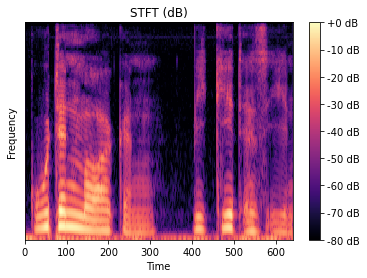

In [32]:
## 4. 데이터 확인하기
for (X_train,Y_train) in train_loader:
    print("X_train : ",X_train.size(),'type:',X_train.type())
    print("Y_train : ",Y_train.size(),'type:',Y_train.type())
    break

librosa.display.specshow(X_train[0].numpy(),
                         sr=sr,
                         hop_length=spectro_hop_length,
                         win_length=spectro_win_length,
                         n_fft=spectro_n_fft)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.xticks(np.arange(0,601,100))
plt.colorbar(format='%+2.0f dB')
plt.title("STFT (dB)")

print(Y_train[0])
print(X_train[0])
#batch: 32 / 3채널 / frame수: 500  /  feature수: 13

X_valid :  torch.Size([16, 128, 641]) type: torch.FloatTensor
Y_valid :  torch.Size([16]) type: torch.LongTensor
tensor(0)


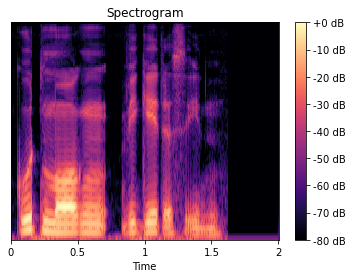

In [33]:
#valiation set 확인
for (X_valid,Y_valid) in validation_loader:
    print("X_valid : ",X_valid.size(),'type:',X_valid.type())
    print("Y_valid : ",Y_valid.size(),'type:',Y_valid.type())
    break

librosa.display.specshow(X_valid[0].numpy(), sr=sr,
                        hop_length=spectro_hop_length,
                         win_length=spectro_win_length,
                         n_fft=spectro_n_fft,
                         x_axis='time'
                         )
#plt.xlabel("Time")
#plt.ylabel("Frequency")
#plt.xticks(np.arange(0,600,100))
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram")
    
    
print(Y_valid[0])
#batch: 32 / 3채널 / frame수: 500  /  feature수: 13

X_test :  torch.Size([16, 128, 641]) type: torch.FloatTensor
Y_test :  torch.Size([16]) type: torch.LongTensor
tensor(1)


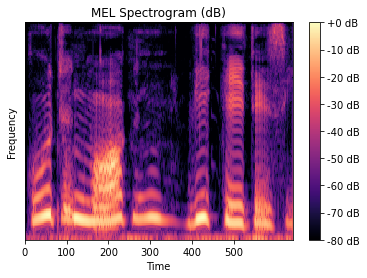

In [35]:
#test set 확인
for (test_data,test_label) in test_loader:
    print("X_test : ",test_data.size(),'type:',test_data.type())
    print("Y_test : ",test_label.size(),'type:',test_label.type())
    break

librosa.display.specshow(test_data[0].numpy(),
                         sr=sr,
                        hop_length=spectro_hop_length,
                         win_length=spectro_win_length,
                         n_fft=spectro_n_fft,)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.xticks(np.arange(0,600,100))
plt.colorbar(format='%+2.0f dB')
plt.title("MEL Spectrogram (dB)")
    
print(test_label[0])

#batch: 32 / 3채널 / frame수: 500  /  feature수: 13

# SEPTR

In [38]:
# This code is released under the CC BY-SA 4.0 license.

import torch
from torch import nn

from einops import rearrange, repeat
from einops.layers.torch import Rearrange


# helpers
def pair(t):
    return t if isinstance(t, tuple) else (t, t)


# classes
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)


class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)


class Attention(nn.Module):
    def __init__(self, dim, heads=8, dim_head=64, dropout=0.):
        super().__init__()
        inner_dim = dim_head * heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim=-1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)


class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout=0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads=heads, dim_head=dim_head, dropout=dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout=dropout))
            ]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x


class Scale(nn.Module):
    def __init__(self, val):
        super().__init__()
        self.val = val

    def forward(self, x):
        return x * self.val


class SepTrBlock(nn.Module):
    def __init__(self, channels, input_size, heads=3, mlp_dim=128, dim_head=32,
                 down_sample_input=None, project=False, reconstruct=False, dim=128, dropout_tr=0.0):
        super().__init__()
        patch_height, patch_width = pair(input_size)
        self.avg_pool = nn.Identity()
        self.upsample = nn.Identity()
        self.projection = nn.Identity()
        self.reconstruction = nn.Identity()

        if down_sample_input is not None:
            patch_height = patch_height // down_sample_input[0]
            patch_width = patch_width // down_sample_input[1]

            self.avg_pool = nn.AvgPool2d(kernel_size=down_sample_input)
            self.upsample = nn.UpsamplingNearest2d(scale_factor=down_sample_input)

        if project:
            self.projection = nn.Linear(channels, dim)
        if reconstruct:
            self.reconstruction = nn.Sequential(
                nn.Linear(dim, channels),
                Scale(dim ** -0.5)
            )

        self.rearrange_patches_h = Rearrange('b c h w -> b w h c')
        self.rearrange_patches_w = Rearrange('b c h w -> b h w c')

        self.rearrange_in_tr = Rearrange('b c h w -> (b c) h w')
        self.rearrange_out_tr_h = Rearrange('(b c) h w -> b w h c', c=patch_width)
        self.rearrange_out_tr_w = Rearrange('(b c) h w -> b w c h', c=patch_height)

        self.pos_embedding_w = nn.Parameter(torch.randn(1, 1, patch_width + 1, dim))
        self.pos_embedding_h = nn.Parameter(torch.randn(1, 1, patch_height + 1, dim))
        self.transformer_w = Transformer(dim, 1, heads, dim_head, mlp_dim, dropout_tr)
        self.transformer_h = Transformer(dim, 1, heads, dim_head, mlp_dim, dropout_tr)

    def forward(self, x, cls_token):
        x = self.avg_pool(x)

        # H inference
        h = self.rearrange_patches_h(x)
        h = self.projection(h)

        dim1, dim2, _, _ = h.shape
        if cls_token.shape[0] == 1:
            cls_token = repeat(cls_token, '() () n d -> b w n d', b=dim1, w=dim2)
        else:
            cls_token = repeat(cls_token, 'b () n d -> b w n d', w=dim2)

        h = torch.cat((cls_token, h), dim=2)
        h += self.pos_embedding_h

        h = self.rearrange_in_tr(h)
        h = self.transformer_h(h)
        h = self.rearrange_out_tr_h(h)

        # W inference
        w = self.rearrange_patches_w(h[:, :, 1:, :])

        cls_token = h[:, :, 0, :].unsqueeze(2)
        cls_token = repeat(cls_token.mean((-1, -2)).unsqueeze(1).unsqueeze(1), 'b () d2 e -> b d1 d2 e', d1=w.shape[1])

        w = torch.cat((cls_token, w), dim=2)
        w += self.pos_embedding_w

        w = self.rearrange_in_tr(w)
        w = self.transformer_w(w)
        w = self.rearrange_out_tr_w(w)

        x = self.upsample(w[:, :, :, 1:])
        x = self.reconstruction(x)

        cls_token = w[:, :, :, 0].mean(2).unsqueeze(1).unsqueeze(1)
        return x, cls_token


In [47]:
# This code is released under the CC BY-SA 4.0 license.

import torch
from torch import nn
from septr_block import SepTrBlock


class SeparableTr(nn.Module):
    def __init__(self, channels=1, input_size=(128, 641), num_classes=2, depth=3, heads=5, mlp_dim=256, dim_head=256,
                 down_sample_input=None, dim=256):
        super().__init__()
        inner_channels = channels

        self.transformer = nn.ModuleList()

        if depth < 1:
            raise Exception("Depth cannot be smaller than 1!")

        self.transformer.append(
            SepTrBlock(channels=inner_channels, input_size=input_size, heads=heads, mlp_dim=mlp_dim,
                       dim_head=dim_head, down_sample_input=down_sample_input, dim=dim, project=True)
        )

        for i in range(1, depth):
            self.transformer.append(
                SepTrBlock(channels=inner_channels, input_size=input_size, heads=heads, mlp_dim=mlp_dim,
                           dim_head=dim_head, down_sample_input=down_sample_input, dim=dim, project=False)
            )

        self.cls_token = nn.Parameter(torch.randn(1, 1, 1, dim))
        self.fc = nn.Linear(dim, num_classes)

    def forward(self, x):
        print(x.size())
        x, cls_token = self.transformer[0](x, self.cls_token)

        for i in range(1, len(self.transformer)):
            x, cls_token = self.transformer[i](x, cls_token)

        cls_token = cls_token[:, 0, 0, :]
        x = self.fc(cls_token)
        return x


In [48]:
def model_initialize():
    model = SeparableTr().cuda()
    return model

model=model_initialize()

In [49]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=lr)
print(model)

SeparableTr(
  (transformer): ModuleList(
    (0): SepTrBlock(
      (avg_pool): Identity()
      (upsample): Identity()
      (projection): Linear(in_features=1, out_features=256, bias=True)
      (reconstruction): Identity()
      (rearrange_patches_h): Rearrange('b c h w -> b w h c')
      (rearrange_patches_w): Rearrange('b c h w -> b h w c')
      (rearrange_in_tr): Rearrange('b c h w -> (b c) h w')
      (rearrange_out_tr_h): Rearrange('(b c) h w -> b w h c', c=641)
      (rearrange_out_tr_w): Rearrange('(b c) h w -> b w c h', c=128)
      (transformer_w): Transformer(
        (layers): ModuleList(
          (0): ModuleList(
            (0): PreNorm(
              (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
              (fn): Attention(
                (attend): Softmax(dim=-1)
                (to_qkv): Linear(in_features=256, out_features=3840, bias=False)
                (to_out): Sequential(
                  (0): Linear(in_features=1280, out_features=256, b

In [50]:
# get the model summary
from torchsummary import summary
#summary(model, input_size=(3, 128, 300), device=DEVICE.type)

In [53]:
#8. 학습
def train(model,train_loader,optimizer, log_interval):
    model.train()
    correct = 0
    train_loss = 0
    for batch_idx,(image,label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        #데이터들 장비에 할당
        optimizer.zero_grad() # device 에 저장된 gradient 제거
        output = model(image) # model로 output을 계산
        loss = criterion(output, label) #loss 계산
        train_loss += loss.item()
        prediction = output.max(1,keepdim=True)[1] # 가장 확률이 높은 class 1개를 가져온다.그리고 인덱스만
        correct += prediction.eq(label.view_as(prediction)).sum().item()# 아웃풋이 배치 사이즈 32개라서.
        loss.backward() # loss 값을 이용해 gradient를 계산
        optimizer.step() # Gradient 값을 이용해 파라미터 업데이트.
    train_loss/=len(train_loader.dataset)
    train_accuracy = 100. * correct / len(train_loader.dataset)
    return train_loss,train_accuracy


In [54]:
#9. 학습 진행하며, validation 데이터로 모델 성능확인
def evaluate(model,valid_loader):
    model.eval()
    valid_loss = 0
    correct = 0
    #no_grad : 그래디언트 값 계산 막기.
    with torch.no_grad():
        for image,label in valid_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            valid_loss += criterion(output, label).item()
            prediction = output.max(1,keepdim=True)[1] # 가장 확률이 높은 class 1개를 가져온다.그리고 인덱스만
            correct += prediction.eq(label.view_as(prediction)).sum().item()# 아웃풋이 배치 사이즈 32개라서.
            #true.false값을 sum해줌. item
        valid_loss /= len(valid_loader.dataset)
        valid_accuracy = 100. * correct / len(valid_loader.dataset)
        return valid_loss,valid_accuracy


In [55]:
#데이터 로더 제작 함수

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)


def load_data(data_ind):

    train_loader = torch.utils.data.DataLoader(dataset = 
                                               svd_dataset(
                                                   X_train_list,
                                                   classes,
                                                   transform = transforms.ToTensor(),#이걸 composed로 고쳐서 전처리 하도록 수정.
                                                   data_num=data_ind,
                                                   #normalize=transforms.Normalize((-11.4805,-54.7723,-54.7723),(16.87,19.0226,19.0226)),
                                                   #mfcc_normalize=(53.5582, 217.43),
                                                   mfcc_params=mfcc_run_config,
                                                   mel_params=mel_run_config,
                                                   spectro_params=spectro_run_config,
                                                   training=True
                                               ),
                                               batch_size = BATCH_SIZE,
                                               shuffle = True,
                                               worker_init_fn=seed_worker
                                               ) # 순서가 암기되는것을 막기위해.

    validation_loader = torch.utils.data.DataLoader(dataset = 
                                               svd_dataset(
                                                   X_valid_list,
                                                   classes,
                                                   transform = transforms.ToTensor(),
                                                   data_num=data_ind,
                                                   #normalize=transforms.Normalize((-11.4805,-54.7723,-54.7723),(16.87,19.0226,19.0226)),
                                                   #mfcc_normalize=(53.5582, 217.43),
                                                   mfcc_params=mfcc_run_config,
                                                   mel_params=mel_run_config,
                                                   spectro_params=spectro_run_config,
                                                   training=False
                                               ),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle = True,
                                                    worker_init_fn=seed_worker) 
    return train_loader,validation_loader



In [56]:
##### 10. 학습 및 평가.
# resnet34 pretrained true
# kfold 적용

train_accs = []
valid_accs = []

for data_ind in range(1,6):

    check_path = '../../../../checkpoint/checkpoint_septr'+str(data_ind)+'_organics_speaker.pt'
    print(check_path)
    early_stopping = EarlyStopping(patience = 5, verbose = True, path=check_path)
    train_loader,validation_loader = load_data(data_ind-1)

    best_train_acc=0 # accuracy 기록용
    best_valid_acc=0
    
    model=model_initialize()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=lr,weight_decay=weight_decay)
    #scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lambda epoch: 0.95 ** epoch)
    #scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,
    #                                               max_lr=0.0001,
    #                                               steps_per_epoch=len(train_loader),
    #                                               epochs=20,
    #                                               anneal_strategy='linear')
    
    
    print("[{} 교차검증] 학습 시작\n ----- ".format(data_ind))
    for Epoch in range(1,EPOCHS+1):
        train_loss,train_accuracy=train(model,train_loader,optimizer,log_interval=31)
        valid_loss,valid_accuracy = evaluate(model, validation_loader)
        wandb.log({
                "valid {}fold Accuracy".format(data_ind) : valid_accuracy,
                "valid {}fold loss".format(data_ind) : valid_loss},
                commit=True,
                step=Epoch)

        print("\n[EPOCH:{}]\t Train Loss:{:.4f}\t Train Acc:{:.2f} %  | \tValid Loss:{:.4f} \tValid Acc: {:.2f} %\n".
              format(Epoch,train_loss,train_accuracy,valid_loss,valid_accuracy))
        

        early_stopping(valid_loss, model)
        if -early_stopping.best_score == valid_loss:
            best_train_acc, best_valid_acc = train_accuracy,valid_accuracy
            wandb.run.summary.update({"best_valid_{}fold_acc".format(data_ind) : best_valid_acc})
        
        if early_stopping.early_stop:
                train_accs.append(best_train_acc)
                valid_accs.append(best_valid_acc)
                print("[{} 교차검증] Early stopping".format(data_ind))
                break

        if Epoch==EPOCHS:
            #만약 early stop 없이 40 epoch라서 중지 된 경우. 
            train_accs.append(best_train_acc)
            valid_accs.append(best_valid_acc)
        #scheduler.step()
        #print(scheduler.get_last_lr())

../../../../checkpoint/checkpoint_septr1_organics_speaker.pt
[1 교차검증] 학습 시작
 ----- 
torch.Size([16, 128, 641])


EinopsError: Expected 4 dimensions, got 3

# Model 결과 확인

In [40]:
sum_valid=0
for data_ind in range(5):
    print("[{} 교차검증] train ACC : {:.4f} |\t valid ACC: {:.4f} ".format(data_ind+1,train_accs[data_ind],valid_accs[data_ind] ))
    sum_valid+=valid_accs[data_ind]
    
print("평균 검증 정확도",sum_valid/5,"%")

[1 교차검증] train ACC : 99.3827 |	 valid ACC: 91.3043 
[2 교차검증] train ACC : 99.5074 |	 valid ACC: 89.5288 
[3 교차검증] train ACC : 99.1400 |	 valid ACC: 87.6190 
[4 교차검증] train ACC : 99.1379 |	 valid ACC: 89.5028 
[5 교차검증] train ACC : 99.1422 |	 valid ACC: 89.6175 
평균 검증 정확도 89.51448800527798 %


# Model Test

- test set
- confusion matrix

In [41]:
#confusion matrix 계산
#test set 계산.
def test_evaluate(model,test_loader):
    model.eval()
    test_loss = 0
    predictions = []
    answers = []
    #no_grad : 그래디언트 값 계산 막기.
    with torch.no_grad():
        for image,mfccs,label in test_loader:
            image = image.to(DEVICE)
            mfccs = mfccs.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image,mfccs)
            test_loss += criterion(output, label).item()
            prediction = output.max(1,keepdim=True)[1] # 가장 확률이 높은 class 1개를 가져온다.그리고 인덱스만
            answers +=label
            predictions +=prediction
            
        return predictions,answers,test_loss
            

In [42]:
# Confusion matrix (resnet18)
# kfold의 confusion matrix는 계산 방법이 다르다.
# 모델을 각각 불러와서 test set을 평가한다.

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

cf = np.zeros((2,2))
cf_list = []
average_accuracy = 0
average_fscore = 0
average_uar = 0

for data_ind in range(1,6):
    model=model_initialize(mfcc_run_config['n_mfcc'])
    check_path = '../../../checkpoint/checkpoint_MSFhyp_ros_stdNorm_'+str(data_ind)+'_organics_speaker.pt'
    model.load_state_dict(torch.load(check_path))

    predictions,answers,test_loss = test_evaluate(model, test_loader)
    predictions=[ dat.cpu().numpy() for dat in predictions]
    answers=[ dat.cpu().numpy() for dat in answers]

    
    cf = confusion_matrix(answers, predictions)
    cf_list.append(cf)
    
    acc = (cf[0,0]+cf[1,1])/(cf[0,0]+cf[0,1]+cf[1,0]+cf[1,1])
    average_accuracy+=acc
    
    precision=cf[1,1]/(cf[0,1]+cf[1,1])
    
    recall=cf[1,1]/(cf[1,1]+cf[1,0])
    
    specificity=cf[0,0]/(cf[0,0]+cf[0,1])
    average_uar += (specificity+recall)/2
    #fscore=2*precision*recall/(precision+recall)
    
    #fscroe macro추가
    fscore = f1_score(answers,predictions,average='macro')
    average_fscore+=fscore
    
    print('{}번 모델'.format(data_ind))
    print("Accuracy : {:.4f}% ".format(acc*100))
    #print("Precision (pathology 예측한 것중 맞는 것) : {:.4f}".format(precision))
    print("recall (실제 pathology 중  예측이 맞는 것) : {:.4f}".format(recall))
    print("specificity : {:.4f}%".format(specificity))
    print("UAR : {:.4f}%".format( (specificity+recall)/2 ))
    
    
    print("f score : {:.4f} ".format(fscore))
    print(cf)
    print("-----")
    #### wandb
    
    wandb.run.summary.update({"test_{}fold_acc".format(data_ind) : acc*100})
    wandb.run.summary.update({"test_{}fold_f1".format(data_ind) : fscore})
    wandb.run.summary.update({"test_{}fold_UAR".format(data_ind) : (specificity+recall)/2})
    wandb.log({"{}fold Confusion Matrix".format(data_ind) :wandb.sklearn.plot_confusion_matrix(answers, predictions, labels=classes)})
    
    ####
    
    
    

print("평균 acc : {:.4f}".format(average_accuracy/5))
print("평균 UAR : {:.4f}".format(average_uar/5))
print("평균 f1score : {:.4f}".format(average_fscore/5))
wandb.run.summary.update({"test 평균 acc" : average_accuracy/5})
wandb.run.summary.update({"test 평균 f1" : average_fscore/5})
wandb.run.summary.update({"test 평균 UAR" : average_uar/5})



1번 모델
Accuracy : 81.4672% 
recall (실제 pathology 중  예측이 맞는 것) : 0.7769
specificity : 0.8527%
UAR : 0.8148%
f score : 0.8144 
[[110  19]
 [ 29 101]]
-----
2번 모델
Accuracy : 79.9228% 
recall (실제 pathology 중  예측이 맞는 것) : 0.7692
specificity : 0.8295%
UAR : 0.7993%
f score : 0.7991 
[[107  22]
 [ 30 100]]
-----
3번 모델
Accuracy : 78.7645% 
recall (실제 pathology 중  예측이 맞는 것) : 0.7077
specificity : 0.8682%
UAR : 0.7880%
f score : 0.7864 
[[112  17]
 [ 38  92]]
-----
4번 모델
Accuracy : 82.2394% 
recall (실제 pathology 중  예측이 맞는 것) : 0.7462
specificity : 0.8992%
UAR : 0.8227%
f score : 0.8214 
[[116  13]
 [ 33  97]]
-----
5번 모델
Accuracy : 81.4672% 
recall (실제 pathology 중  예측이 맞는 것) : 0.7538
specificity : 0.8760%
UAR : 0.8149%
f score : 0.8140 
[[113  16]
 [ 32  98]]
-----
평균 acc : 0.8077
평균 UAR : 0.8079
평균 f1score : 0.8071


In [43]:
ㅇㅇㅇㅇㅇㅇㅇㅇㅇ

NameError: name 'ᄋᄋᄋᄋᄋᄋᄋᄋᄋ' is not defined

# loss 시각화

In [ ]:
plt.plot(train_loss_list[0])
plt.plot(valid_loss_list[0])
plt.show()

In [ ]:
plt.plot(train_loss_list[1])
plt.plot(valid_loss_list[1])
plt.show()

In [ ]:
plt.plot(train_loss_list[2])
plt.plot(valid_loss_list[2])
plt.show()

In [ ]:
plt.plot(train_loss_list[3])
plt.plot(valid_loss_list[3])
plt.show()

In [ ]:
plt.plot(train_loss_list[4])
plt.plot(valid_loss_list[4])
plt.show()

In [ ]:
plt.plot(train_accs_list[0])
plt.plot(valid_accs_list[0])
plt.show()

In [ ]:
plt.plot(train_accs_list[1])
plt.plot(valid_accs_list[1])
plt.show()

In [ ]:
plt.plot(train_accs_list[2])
plt.plot(valid_accs_list[2])
plt.show()

In [ ]:
plt.plot(train_accs_list[3])
plt.plot(valid_accs_list[3])
plt.show()

In [ ]:
plt.plot(train_accs_list[4])
plt.plot(valid_accs_list[4])
plt.show()

# 기타

In [ ]:
#크기 알아보기
#일반 CNN

m = nn.MaxPool2d(2, stride=2)
#m = nn.MaxPool2d((3, 2), stride=(2, 1))
input = torch.randn(32, 1, 500, 13)
print(input.size())
output = m(input)
print(output.size())
output = m(output)
print(output.size())

In [ ]:
#크기 알아보기
#주파수 영역 CNN

input = torch.randn(32, 1, 500, 13)
m=nn.Conv2d(
            in_channels = 1,# 채널이 1개
            out_channels = 32,# FeatureMap 수,커널 수
            kernel_size = (1,13),#1x13  no padding
        )
output=m(input)
print(output.size())
m=nn.Conv2d(
            in_channels = 32,# 채널이 1개
            out_channels = 64,# FeatureMap 수,커널 수
            kernel_size = (27,1),#9 x 1 no padding
        )
output=m(output)
print(output.size())


In [ ]:
input = torch.randn(500, 13)

out=torch.stack([input,input,input])
out.size()

In [ ]:
all_train_accs
all_valid_accs

all_train_loss_list
all_valid_loss_list



In [ ]:
length=300
mel_feature=pathology[0]
transform_norm = transforms.ToTensor()

pad2d = lambda a, i: a[:, 0:i] if a.shape[1] > i else np.hstack((a, np.zeros((a.shape[0], i-a.shape[1]))))
mel_feature = pad2d(mel_feature, length)
mel_feature = transform_norm(mel_feature)




In [ ]:
mel_feature

In [ ]:
librosa.util.normalize(mel_feature.squeeze().numpy())

In [ ]:
mel_feature.size()

In [ ]:
from torch.autograd import Variable
from torchvision.utils import make_grid, save_image

#model.eval()

#pathology 음성 파일 가져오기

length=300
mel_sample=healthy[0]
image_list=[]
transform_norm = transforms.ToTensor()

pad2d = lambda a, i: a[:, 0:i] if a.shape[1] > i else np.hstack((a, np.zeros((a.shape[0], i-a.shape[1]))))
mel_sample = pad2d(mel_sample, length)
mel_sample = transform_norm(mel_sample)
mel_sample=torch.stack([mel_sample,mel_sample,mel_sample])# 3채널로 복사.
mel_sample=mel_sample.squeeze(1)
mel_sample=mel_sample.unsqueeze(0).to(DEVICE).float()
print(mel_sample.squeeze()[0])


In [ ]:
mel_sample.squeeze()[0]

# grad cam
- https://www.secmem.org/blog/2020/01/17/gradcam/
- https://blog.naver.com/PostView.nhn?blogId=domodal&logNo=221485292052&parentCategoryNo=&categoryNo=10&viewDate=&isShowPopularPosts=true&from=search
- f1-score가 가장높은 5번 모델 cam 확인
- 마지막 feature map 부터 output 까지의 gradient를 계산해야한다.
- https://sanghyu.tistory.com/46 normalize

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn # 인공 신경망 모델들 모아놓은 모듈
import torch.nn.functional as F #그중 자주 쓰이는것들을 F로
from torchvision import transforms, datasets
import cv2
from torchvision import transforms, datasets
import pandas as pd
import os
from glob import glob
import torchvision.models as models
import sys

p = os.path.abspath('../..') # 상위 폴더를 사용하기 위해서.
sys.path.insert(1, p)
from pytorchtools.pytorchtools import EarlyStopping # 상위 폴더에 추가된 모듈.



if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
#DEVICE = torch.device('cpu')
print('Using Pytorch version : ',torch.__version__,' Device : ',DEVICE)

In [ ]:
import numpy as np
import librosa, librosa.display 
import matplotlib.pyplot as plt
#window sizde : FFT를 할때 참조할 그래프 길이 ( 프레임 하나당 sample 수 )
#자연어 처리에서는 25ms 사용. https://ahnjg.tistory.com/93
#초당 50000hz 중 1250개씩 윈도우 사이즈로 사용.
sr=50000
win_length =  np.int64(50000/40) # 1250
n_fft= win_length # WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding
hop_length= np.int64( np.ceil(win_length/4) ) #  얼마만큼 시간 주기(sample)를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4
#또는 10ms만큼으로 한다고 한다.
#hop_length가 mfcc의 frame수를 결정한다.

pathology_sig=[]
healthy_sig=[]

pathology=[]
healthy=[]



#PATHOLOGY DATA
for audio_path in os.listdir('../../../voice_data/pathology_new/phrase/export'):
    sig, sr = librosa.load('../../../voice_data/pathology_new/phrase/export/'+audio_path, sr=50000)# 논문에서 f_s = 50 000HZ
    pathology_sig.append(sig)
    mel_feature = librosa.feature.melspectrogram(sig,sr=sr,hop_length=hop_length,n_fft=n_fft)
    mel_feature = librosa.core.power_to_db(mel_feature,ref=np.max)
    pathology.append(mel_feature)
    

#Healthy data
for audio_path in os.listdir('../../../voice_data/healthy_new/phrase/export'):
    sig, sr = librosa.load('../../../voice_data/healthy_new/phrase/export/'+audio_path, sr=50000)# 논문에서 f_s = 50 000HZ
    healthy_sig.append(sig)
    mel_feature = librosa.feature.melspectrogram(sig,sr=sr,hop_length=hop_length,n_fft=n_fft)
    mel_feature = librosa.core.power_to_db(mel_feature,ref=np.max)
    healthy.append(mel_feature)
    
print("pathology data 수 : ",len(pathology))
print("healthy data 수 : ",len(healthy))


path_max=max([ len(samples) for samples in pathology_sig])
healthy_max=max([ len(samples) for samples in healthy_sig])
print("가장 긴 path sample :" ,path_max)
print("가장 긴 healthy sample :" ,healthy_max)

In [ ]:
# final conv layer name 
finalconv_name = 'layer4'

# activations
feature_blobs = []

# gradient를 가져올 hook 함수
backward_feature = []

transform_norm = transforms.ToTensor()

# output으로 나오는 feature를 feature_blobs에 append하도록
def hook_feature(module, input, output):
    feature_blobs.append(output.cpu().data.numpy()) # 레이어의 마지막 output(피처맵)을 구하는 함수
    

# Grad-CAM
def backward_hook(module, input, output):
    backward_feature.append(output[0])  #backward시에 그래디언트 저장.

In [ ]:
# 모델 수정해서 hook 추가 사용.



def model_initialize():
    model = models.resnet18(pretrained=True).cuda()
    model.ftrs = model.fc.in_features # in_features : fully connected의 입력수.
    num_ftrs = model.fc.in_features
    
    model.layer4.register_forward_hook(hook_feature)
    model.layer4.register_backward_hook(backward_hook)
    
    model.fc = nn.Sequential(nn.Linear(num_ftrs, 256),
                             nn.BatchNorm1d(256),
                             nn.ReLU(),
                             nn.Dropout(p=0.5),
                             nn.Linear(256,128),
                             nn.BatchNorm1d(128),
                             nn.ReLU(),
                             nn.Dropout(p=0.5),
                             nn.Linear(128,64),
                             nn.BatchNorm1d(64),
                             nn.ReLU(),
                             nn.Dropout(p=0.5),
                             nn.Linear(64,50),
                             nn.BatchNorm1d(50),
                             nn.ReLU(),
                             nn.Dropout(p=0.5),
                             nn.Linear(50,2)
                            )

    model = model.cuda()
    return model
model=model_initialize()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)

check_path = '../../checkpoint/checkpoint_melspectro_resnet18_true_ros_1_300.pt'
model.load_state_dict(torch.load(check_path))
print(model)


In [ ]:
grad_result[]

마지막 cnn layer는 layer4로 볼 수 있다.

In [ ]:
from torch.autograd import Variable
from torchvision.utils import make_grid, save_image
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

model.eval()

#pathology 음성 파일 가져오기

length=300
mel_sample=pathology[0]
image_list=[]

# activations
feature_blobs = []

# gradient를 가져올 hook 함수
backward_feature = []


pad2d = lambda a, i: a[:, 0:i] if a.shape[1] > i else np.hstack((a, np.zeros((a.shape[0], i-a.shape[1]))))
mel_sample = pad2d(mel_sample, length)
mel_sample = transform_norm(mel_sample)
mel_sample=torch.stack([mel_sample,mel_sample,mel_sample])# 3채널로 복사.
mel_sample=mel_sample.squeeze(1)
mel_sample=mel_sample.unsqueeze(0).to(DEVICE).float()


model._modules.get(finalconv_name).register_forward_hook(hook_feature)
model._modules.get(finalconv_name).register_backward_hook(backward_hook)



# Prediction
logit = model(mel_sample) # 예측값 구하기.
out = F.softmax(logit, dim=1).data.squeeze() # softmax 적용 (모델을 통과는 했지만, criterion는 안통과함.)
probs, idx = out.sort(0, True)
print("Predicted label : %d, Probability : %.2f" % (idx[0].item(), probs[0].item()))

###########
# Grad - cam
###########

score = logit[:, idx[0]].squeeze() # 예측값 y^c.
score.backward(retain_graph = True) # 예측값 y^c에 대해서 backprop 진행
    
activations = torch.Tensor(feature_blobs[0]).to(DEVICE) # (1, 512, 7, 7), forward activations. append라서 0번이 마지막
gradients = backward_feature[0] # (1, 512, 4, 10), backward gradients. 마지막 conv layer의 gradient
b, k, u, v = gradients.size()  # batch, 피처맵 수,  상, 하
print(gradients.size())

alpha = gradients.view(b, k, -1).mean(2) # (1, 512, 7*7) => (1, 512), feature map k의 'importance'
weights = alpha.view(b, k, 1, 1) # (1, 512, 1, 1)

grad_cam_map = (weights*activations).sum(1, keepdim = True) # alpha * A^k = (1, 512, 7, 7) => (1, 1, 7, 7)
grad_cam_map = F.relu(grad_cam_map) # Apply R e L U
grad_cam_map = F.interpolate(grad_cam_map, size=(128, 300), mode='bilinear', align_corners=False) # (1, 1, 224, 224)
map_min, map_max = grad_cam_map.min(), grad_cam_map.max()
grad_cam_map = (grad_cam_map - map_min).div(map_max - map_min).data # (1, 1, 128, 300), min-max scaling

grad_heatmap = cv2.applyColorMap(np.uint8(255 * grad_cam_map.squeeze().cpu()), cv2.COLORMAP_JET) # (224, 224, 3), numpy 
grad_heatmap = torch.from_numpy(grad_heatmap).permute(2, 0, 1).float().div(255) # (3, 244, 244)



#save_image(grad_heatmap, os.path.join("./", "Grad_CAM.jpg"))
r=torch.from_numpy(scaler.fit_transform(mel_sample.squeeze().cpu()[0]))
g=torch.from_numpy(scaler.fit_transform(mel_sample.squeeze().cpu()[1]))
b=torch.from_numpy(scaler.fit_transform(mel_sample.squeeze().cpu()[2]))

grad_result = grad_heatmap + torch.stack([r,g,b]) # (1, 3, 128, 300)
grad_result = grad_result.div(grad_result.max()).squeeze().permute(1, 2, 0)


#mel_sample = librosa.util.normalize(mel_sample.cpu().squeeze().numpy()[0])

#grad_result = grad_heatmap.numpy() + mel_sample # (1, 3, 244, 244)


plt.figure(figsize=(15,10))


plt.subplot(131)
librosa.display.specshow(mel_sample.cpu().squeeze().numpy()[0], sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram (dB)")


plt.subplot(132)
plt.imshow(grad_heatmap.permute(1, 2, 0).numpy())
plt.gca().invert_yaxis()

plt.subplot(133)
plt.imshow(grad_result)
plt.gca().invert_yaxis()


In [ ]:
torch.stack([r,g,b]).size()

In [ ]:
mel_sample.shape

In [ ]:
grad_result.size()

In [ ]:
np.min(grad_result.permute(1, 2, 0).numpy())

In [ ]:
from torch.autograd import Variable
from torchvision.utils import make_grid, save_image

model.eval()

#pathology 음성 파일 가져오기

length=300
mel_sample=pathology[50]
image_list=[]

# activations
feature_blobs = []

# gradient를 가져올 hook 함수
backward_feature = []


pad2d = lambda a, i: a[:, 0:i] if a.shape[1] > i else np.hstack((a, np.zeros((a.shape[0], i-a.shape[1]))))
mel_sample = pad2d(mel_sample, length)
mel_sample = transform_norm(mel_sample)
mel_sample=torch.stack([mel_sample,mel_sample,mel_sample])# 3채널로 복사.
mel_sample=mel_sample.squeeze(1)
mel_sample=mel_sample.unsqueeze(0).to(DEVICE).float()


model._modules.get(finalconv_name).register_forward_hook(hook_feature)
model._modules.get(finalconv_name).register_backward_hook(backward_hook)



# Prediction
logit = model(mel_sample) # 예측값 구하기.
out = F.softmax(logit, dim=1).data.squeeze() # softmax 적용 (모델을 통과는 했지만, criterion는 안통과함.)
probs, idx = out.sort(0, True)
print("Predicted label : %d, Probability : %.2f" % (idx[0].item(), probs[0].item()))

###########
# Grad - cam
###########

score = logit[:, idx[0]].squeeze() # 예측값 y^c.
score.backward(retain_graph = True) # 예측값 y^c에 대해서 backprop 진행
    
activations = torch.Tensor(feature_blobs[0]).to(DEVICE) # (1, 512, 7, 7), forward activations. append라서 0번이 마지막
gradients = backward_feature[0] # (1, 512, 4, 10), backward gradients. 마지막 conv layer의 gradient
b, k, u, v = gradients.size()  # batch, 피처맵 수,  상, 하
print(gradients.size())

alpha = gradients.view(b, k, -1).mean(2) # (1, 512, 7*7) => (1, 512), feature map k의 'importance'
weights = alpha.view(b, k, 1, 1) # (1, 512, 1, 1)

grad_cam_map = (weights*activations).sum(1, keepdim = True) # alpha * A^k = (1, 512, 7, 7) => (1, 1, 7, 7)
grad_cam_map = F.relu(grad_cam_map) # Apply R e L U
grad_cam_map = F.interpolate(grad_cam_map, size=(128, 300), mode='bilinear', align_corners=False) # (1, 1, 224, 224)
map_min, map_max = grad_cam_map.min(), grad_cam_map.max()
grad_cam_map = (grad_cam_map - map_min).div(map_max - map_min).data # (1, 1, 128, 300), min-max scaling
    
grad_heatmap=grad_cam_map.squeeze().cpu()
# grad_cam_map.squeeze() : (128, 300)

save_image(grad_heatmap, os.path.join("./", "Grad_CAM.jpg"))





mel_sample = librosa.util.normalize(mel_sample.cpu().squeeze().numpy()[0])

grad_result = grad_heatmap.numpy() + mel_sample # (1, 3, 244, 244)


plt.figure(figsize=(20,15))

plt.subplot(331)
librosa.display.specshow(mel_sample, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram (dB)")


plt.subplot(332)
librosa.display.specshow(grad_heatmap.numpy(), sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram (dB)")

plt.subplot(333)
librosa.display.specshow(grad_result, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram (dB)")



In [ ]:
from torch.autograd import Variable
from torchvision.utils import make_grid, save_image

model.eval()

#pathology 음성 파일 가져오기

length=300
mel_sample=healthy[0]
image_list=[]


pad2d = lambda a, i: a[:, 0:i] if a.shape[1] > i else np.hstack((a, np.zeros((a.shape[0], i-a.shape[1]))))
mel_sample = pad2d(mel_sample, length)
mel_sample = transform_norm(mel_sample)
mel_sample=torch.stack([mel_sample,mel_sample,mel_sample])# 3채널로 복사.
mel_sample=mel_sample.squeeze(1)
mel_sample=mel_sample.unsqueeze(0).to(DEVICE).float()
print(mel_sample)

model._modules.get(finalconv_name).register_forward_hook(hook_feature)
model._modules.get(finalconv_name).register_backward_hook(backward_hook)



# Prediction
logit = model(mel_sample) # 예측값 구하기.
out = F.softmax(logit, dim=1).data.squeeze() # softmax 적용 (모델을 통과는 했지만, criterion는 안통과함.)
probs, idx = out.sort(0, True)
print("Predicted label : %d, Probability : %.2f" % (idx[0].item(), probs[0].item()))

###########
# Grad - cam
###########

score = logit[:, idx[0]].squeeze() # 예측값 y^c.
score.backward(retain_graph = True) # 예측값 y^c에 대해서 backprop 진행
    
activations = torch.Tensor(feature_blobs[0]).to(DEVICE) # (1, 512, 7, 7), forward activations. append라서 0번이 마지막
gradients = backward_feature[0] # (1, 512, 4, 10), backward gradients. 마지막 conv layer의 gradient
b, k, u, v = gradients.size()  # batch, 피처맵 수,  상, 하
print(gradients.size())

alpha = gradients.view(b, k, -1).mean(2) # (1, 512, 7*7) => (1, 512), feature map k의 'importance'
weights = alpha.view(b, k, 1, 1) # (1, 512, 1, 1)

grad_cam_map = (weights*activations).sum(1, keepdim = True) # alpha * A^k = (1, 512, 7, 7) => (1, 1, 7, 7)
grad_cam_map = F.relu(grad_cam_map) # Apply R e L U
grad_cam_map = F.interpolate(grad_cam_map, size=(128, 300), mode='bilinear', align_corners=False) # (1, 1, 224, 224)
map_min, map_max = grad_cam_map.min(), grad_cam_map.max()
grad_cam_map = (grad_cam_map - map_min).div(map_max - map_min).data # (1, 1, 128, 300), min-max scaling
    
grad_heatmap=grad_cam_map.squeeze().cpu()
# grad_cam_map.squeeze() : (128, 300)

save_image(grad_heatmap, os.path.join("./", "Grad_CAM.jpg"))





mel_sample = librosa.util.normalize(mel_sample.cpu().squeeze().numpy()[0])

grad_result = grad_heatmap.numpy() + mel_sample # (1, 3, 244, 244)


plt.figure(figsize=(20,15))

plt.subplot(331)
librosa.display.specshow(mel_sample, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram (dB)")


plt.subplot(332)
librosa.display.specshow(grad_heatmap.numpy(), sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram (dB)")

plt.subplot(333)
librosa.display.specshow(grad_result, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram (dB)")



In [ ]:
plt.imshow(grad_heatmap*255)

In [ ]:
mel_feature

In [ ]:
grad_heatmap.permute(1,2,0).size()

In [ ]:
backward_feature[0]

In [ ]:
activations # 피처맵

In [ ]:
logit[:, idx[0]].squeeze() 

In [ ]:
backward_feature

In [ ]:
out

In [ ]:
datas = Variable(mel_feature)#  미분가능한 torch 데이터로 변환되고
feature = datas.data
print(feature.size())

In [ ]:
datas